**NOTE: MAJOR ISSUES, WILL REDO**

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import lightgbm
import imblearn

from collections import Counter
from glob import glob
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from utils.merge_tools import set_table_dtypes

# Class Balance and Missing Values


We will attempt to fillna and balance classes.

The data group `train_credit_bureau_a_1` will be used as a sample set.

In [2]:
data_dir = '../data/raw/parquet_files/train'
base_file_path = '../data/raw/parquet_files/train/train_base.parquet'
cb_a_1_paths = glob(os.path.join(data_dir, 'train_credit_bureau_a_1') + '*')

In [3]:
# Combine all credit cases into 1 DataFrame
df = pl.DataFrame()
for path in cb_a_1_paths:
    df = pl.concat([df, pl.read_parquet(path).pipe(set_table_dtypes)], how='vertical')

In [4]:
# Count dtypes
Counter(df.dtypes)

Counter({Float64: 54, Date: 12, String: 11, Int64: 2})

High dimensional categorical data will be reduced to top 5 categories and 'other'.

In [5]:
print('Number of unique categories by column:')
for col in df.select(pl.selectors.by_dtype(pl.String)).columns:
    print(f'{col}: {df[col].n_unique()} categories, {df[col].is_null().sum()} null values')

Number of unique categories by column:
classificationofcontr_13M: 11 categories, 0 null values
classificationofcontr_400M: 389 categories, 0 null values
contractst_545M: 51 categories, 0 null values
contractst_964M: 295 categories, 0 null values
description_351M: 12 categories, 0 null values
financialinstitution_382M: 390 categories, 0 null values
financialinstitution_591M: 238 categories, 0 null values
purposeofcred_426M: 19 categories, 0 null values
purposeofcred_874M: 24 categories, 0 null values
subjectrole_182M: 9 categories, 0 null values
subjectrole_93M: 9 categories, 0 null values


In [6]:
def create_is_null_cols(df: pl.DataFrame) -> pl.DataFrame:
    for col in df.columns:
        if df[col].is_null().sum() > 0:
            df = df.with_columns(df[col].is_null().alias(f'{col}_is_null'))
    
    return df

In [7]:
# Create columns to indicate where null will be filled
df_null_cols = create_is_null_cols(df)

In [8]:
def get_top_categories(df: pl.DataFrame, n_cat: int = 5) -> pl.DataFrame:
    cols = df.select(pl.selectors.by_dtype(pl.String)).columns
    for col in cols:
        if df[col].n_unique() > n_cat:
            top_n_list = df[col].value_counts(sort=True)[:n_cat][col].to_list()
            df = df.with_columns(
                pl.when(pl.col(col).is_in(top_n_list))
                .then(pl.col(col))
                .otherwise(pl.lit('other'))
            )
        
    return df

In [9]:
# Convert columns to top categories
df_top_cat = get_top_categories(df_null_cols, 10)

In [10]:
# Split data to personal and non-personal
df_per = df_top_cat.filter(pl.col('num_group1') == 0)
df_non = df_top_cat.filter(pl.col('num_group1') != 0)

# Get base data
df_base = pl.read_parquet(base_file_path)
df_base = df_base.with_columns(pl.col('date_decision').str.to_date())

In [11]:
def separate_dates(df: pl.DataFrame, date_cols: list[str] = []) -> pl.DataFrame:
    date_df = df.select(date_cols)

    for col in date_cols:
        date_df = date_df.with_columns(pl.col(col).dt.year().alias(col + '_year'))
        date_df = date_df.with_columns(pl.col(col).dt.month().alias(col + '_month'))
        date_df = date_df.with_columns(pl.col(col).dt.day().alias(col + '_day'))
        date_df.drop_in_place(col)

    date_df = pl.concat([df.select('case_id'), date_df], how='horizontal')

    return date_df

In [12]:
# Separate dates in base
df_base_date = separate_dates(df_base, ['date_decision'])
df_base_final = df_base.drop(['date_decision', 'MONTH']).join(df_base_date, on='case_id')

# Separate dates in personal data
date_cols = [ df_per.columns[i] for i in range(len(df_per.columns)) if df_per.dtypes[i] == pl.Date ]
df_per_date = separate_dates(df_per, date_cols)

# Get categorical columns
cat_cols = [ 
    df.columns[i] for i in range(len(df.columns)) 
    if df.dtypes[i] == pl.String
]
df_per_cat = df_per.select(['case_id'] + cat_cols)

# Get numerical columns
num_cols = [ 
    df_per.columns[i] for i in range(len(df_per.columns)) 
    if (df_per.columns[i] != 'case_id') and ((df_per.dtypes[i] == pl.Float64) or (df_per.dtypes[i] == pl.Int64))
]
df_per_num = df_per.select(['case_id'] + num_cols)

# Get bool columns
bool_cols = [
    df_per.columns[i] for i in range(len(df_per.columns))
    if df_per.dtypes[i] == pl.Boolean
]
df_per_bool = df_per.select(['case_id'] + bool_cols)

# Join all DataFrames
df_per_final = df_base_final.join(df_per_date, on='case_id')
df_per_final = df_per_final.join(df_per_cat, on='case_id')
df_per_final = df_per_final.join(df_per_num, on='case_id')
df_per_final = df_per_final.join(df_per_bool, on='case_id')

In [62]:
df_per_final.head()

case_id,WEEK_NUM,target,date_decision_year,date_decision_month,date_decision_day,dateofcredend_289D_year,dateofcredend_289D_month,dateofcredend_289D_day,dateofcredend_353D_year,dateofcredend_353D_month,dateofcredend_353D_day,dateofcredstart_181D_year,dateofcredstart_181D_month,dateofcredstart_181D_day,dateofcredstart_739D_year,dateofcredstart_739D_month,dateofcredstart_739D_day,dateofrealrepmt_138D_year,dateofrealrepmt_138D_month,dateofrealrepmt_138D_day,lastupdate_1112D_year,lastupdate_1112D_month,lastupdate_1112D_day,lastupdate_388D_year,lastupdate_388D_month,lastupdate_388D_day,numberofoverdueinstlmaxdat_148D_year,numberofoverdueinstlmaxdat_148D_month,numberofoverdueinstlmaxdat_148D_day,numberofoverdueinstlmaxdat_641D_year,numberofoverdueinstlmaxdat_641D_month,numberofoverdueinstlmaxdat_641D_day,overdueamountmax2date_1002D_year,overdueamountmax2date_1002D_month,overdueamountmax2date_1002D_day,overdueamountmax2date_1142D_year,…,numberofinstls_229L_is_null,numberofinstls_320L_is_null,numberofoutstandinstls_520L_is_null,numberofoutstandinstls_59L_is_null,numberofoverdueinstlmax_1039L_is_null,numberofoverdueinstlmax_1151L_is_null,numberofoverdueinstlmaxdat_148D_is_null,numberofoverdueinstlmaxdat_641D_is_null,numberofoverdueinstls_725L_is_null,numberofoverdueinstls_834L_is_null,outstandingamount_354A_is_null,outstandingamount_362A_is_null,overdueamount_31A_is_null,overdueamount_659A_is_null,overdueamountmax2_14A_is_null,overdueamountmax2_398A_is_null,overdueamountmax2date_1002D_is_null,overdueamountmax2date_1142D_is_null,overdueamountmax_155A_is_null,overdueamountmax_35A_is_null,overdueamountmaxdatemonth_284T_is_null,overdueamountmaxdatemonth_365T_is_null,overdueamountmaxdateyear_2T_is_null,overdueamountmaxdateyear_994T_is_null,periodicityofpmts_1102L_is_null,periodicityofpmts_837L_is_null,prolongationcount_1120L_is_null,prolongationcount_599L_is_null,refreshdate_3813885D_is_null,residualamount_488A_is_null,residualamount_856A_is_null,totalamount_6A_is_null,totalamount_996A_is_null,totaldebtoverduevalue_178A_is_null,totaldebtoverduevalue_718A_is_null,totaloutstanddebtvalue_39A_is_null,totaloutstanddebtvalue_668A_is_null
i64,i64,i64,i32,i8,i8,i32,i8,i8,i32,i8,i8,i32,i8,i8,i32,i8,i8,i32,i8,i8,i32,i8,i8,i32,i8,i8,i32,i8,i8,i32,i8,i8,i32,i8,i8,i32,…,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
388,1,0,2019,1,14,2023,6,20,null,null,null,null,null,null,2018,6,20,null,null,null,2019,1,24,null,null,null,null,null,null,null,null,null,null,null,null,null,…,true,false,true,false,false,true,true,true,false,true,true,false,true,false,false,true,true,true,false,true,true,false,false,true,true,false,true,true,true,true,true,true,false,false,false,false,false
405,1,0,2019,1,8,2020,6,6,null,null,null,null,null,null,2012,6,6,null,null,null,2019,1,11,null,null,null,null,null,null,null,null,null,null,null,null,null,…,true,true,true,true,false,true,true,true,false,true,true,true,true,false,false,true,true,true,false,true,true,false,false,true,true,true,true,true,true,true,false,true,true,false,true,false,true
409,1,0,2019,1,8,2019,9,9,null,null,null,null,null,null,2016,9,9,null,null,null,2019,1,3,null,null,null,null,null,null,null,null,null,null,null,null,null,…,true,false,true,false,false,true,true,true,false,true,true,false,true,false,false,true,true,true,false,true,true,false,false,true,true,false,true,true,true,true,true,true,false,false,false,false,false
410,1,0,2019,1,8,2019,4,17,null,null,null,null,null,null,2017,4,17,null,null,null,2019,1,11,null,null,null,null,null,null,null,null,null,null,null,null,null,…,true,true,true,true,false,true,true,true,false,true,true,true,true,false,false,true,true,true,false,true,true,false,false,true,true,true,true,true,true,true,false,true,true,false,false,false,false
411,1,0,2019,1,8,2020,9,25,null,null,null,null,null,null,2012,9,25,null,null,null,2019,1,11,null,null,nul

In [63]:
X = df_per_final.drop(['target', 'case_id', 'MONTH', 'num_group1']).to_pandas()
y = df_per_final['target'].to_pandas().values
features = X.columns

In [64]:
X.dtypes.value_counts()

float64    90
bool       66
object     11
int8        2
int64       1
int32       1
Name: count, dtype: int64

In [65]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## Impute values from train set

In [66]:
train_df = pd.DataFrame(X_train, columns=features)
val_df = pd.DataFrame(X_val, columns=features)

train_df['target'] = y_train
val_df['target'] = y_val

In [67]:
def impute_num_mean_cat_mode_by_target(train_df: pd.DataFrame, val_df: pd.DataFrame):
    new_train_df = train_df.copy(deep=True)
    new_val_df = val_df.copy(deep=True)

    for col in new_train_df.columns:
        if new_train_df[col].dtype in ['float64', 'int64', 'int8', 'int32']:
            # Get means
            mean_values = new_train_df.groupby('target')[col].mean()
            mean_0 = mean_values[0] if not pd.isna(mean_values[0]) else 0
            mean_1 = mean_values[1] if not pd.isna(mean_values[1]) else 0

            new_train_df.loc[new_train_df['target'] == 0, col] = new_train_df.loc[new_train_df['target'] == 0, col].fillna(mean_0)
            new_train_df.loc[new_train_df['target'] == 1, col] = new_train_df.loc[new_train_df['target'] == 1, col].fillna(mean_1)
            new_val_df.loc[new_val_df['target'] == 0, col] = new_val_df.loc[new_val_df['target'] == 0, col].fillna(mean_0)
            new_val_df.loc[new_val_df['target'] == 1, col] = new_val_df.loc[new_val_df['target'] == 1, col].fillna(mean_1)
        elif new_train_df[col].dtype == 'object':
            # Get modes
            mode_values = new_train_df.groupby('target')[col].agg(pd.Series.mode)
            mode_0 = mode_values[0] if not pd.isna(mode_values[0]) else 'MISSING'
            mode_1 = mode_values[1] if not pd.isna(mode_values[1]) else 'MISSING'

            new_train_df.loc[new_train_df['target'] == 0, col] = new_train_df.loc[new_train_df['target'] == 0, col].fillna(mode_0)
            new_train_df.loc[new_train_df['target'] == 1, col] = new_train_df.loc[new_train_df['target'] == 1, col].fillna(mode_1)
            new_val_df.loc[new_val_df['target'] == 0, col] = new_val_df.loc[new_val_df['target'] == 0, col].fillna(mode_0)
            new_val_df.loc[new_val_df['target'] == 1, col] = new_val_df.loc[new_val_df['target'] == 1, col].fillna(mode_1)

    new_train_df = new_train_df.drop(columns=['target'])
    new_val_df = new_val_df.drop(columns=['target'])

    return new_train_df, new_val_df

In [68]:
imp_X_train, imp_X_val = impute_num_mean_cat_mode_by_target(train_df, val_df)

In [69]:
# Get dummies
to_dummies_cols = imp_X_train.select_dtypes(include=['object']).columns.tolist()
onehot = OneHotEncoder(handle_unknown='ignore')
train_dummies = onehot.fit_transform(imp_X_train[to_dummies_cols])
val_dummies = onehot.transform(imp_X_val[to_dummies_cols])

In [70]:
train_dummies_df = pd.DataFrame(train_dummies.toarray(), columns=onehot.get_feature_names_out(input_features=to_dummies_cols), index=imp_X_train.index)
val_dummies_df = pd.DataFrame(val_dummies.toarray(), columns=onehot.get_feature_names_out(input_features=to_dummies_cols), index=imp_X_val.index)

imp_X_train_no_cat = imp_X_train.drop(columns=to_dummies_cols)
imp_X_val_no_cat = imp_X_val.drop(columns=to_dummies_cols)

imp_X_train_encoded = pd.concat([imp_X_train_no_cat, train_dummies_df], axis=1)
imp_X_val_encoded = pd.concat([imp_X_val_no_cat, val_dummies_df], axis=1)

In [71]:
imp_X_train_encoded

,WEEK_NUM,date_decision_year,date_decision_month,date_decision_day,dateofcredend_289D_year,dateofcredend_289D_month,dateofcredend_289D_day,dateofcredend_353D_year,dateofcredend_353D_month,dateofcredend_353D_day,...,subjectrole_182M_a55475b1,subjectrole_182M_ab3c25cf,subjectrole_182M_be4fd70b,subjectrole_182M_daf49a8a,subjectrole_93M_15f04f45,subjectrole_93M_71ddaa88,subjectrole_93M_a55475b1,subjectrole_93M_ab3c25cf,subjectrole_93M_be4fd70b,subjectrole_93M_daf49a8a
984190,84,2020,8,11,2021.0,7.0,27.0,2007.000000,1.000000,5.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
770285,46,2019,11,20,2020.0,9.0,8.0,2010.000000,11.000000,8.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
543160,49,2019,12,12,2020.0,4.0,30.0,2014.000000,6.000000,27.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
180466,9,2019,3,5,2021.0,1.0,18.0,2012.929998,6.628503,15.921816,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
625400,32,2019,8,18,2021.0,7.0,29.0,2015.000000,8.000000,30.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370753,35,2019,9,6,2021.0,2.0,5.0,2017.000000,1.000000,17.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
922627,76,2020,6,16,2020.0,9.0,30.0,2010.000000,7.000000,12.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
836635,30,2019,7,30,2019.0,11.0,2.0,2009.000000,5.000000,8.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1192912,50,2019,12,18,2020.0,5.0,25.0,2018.000000,9.000000,23.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [81]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": ["auc", "binary_logloss"],
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 5000,
    "verbose": -1,
}

In [82]:
lgb_train = lightgbm.Dataset(imp_X_train_encoded, label=y_train)
lgb_valid = lightgbm.Dataset(imp_X_val_encoded, label=y_val, reference=lgb_train)

model = lightgbm.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lightgbm.log_evaluation(100), lightgbm.early_stopping(100)]
)

/Users/waynelam/Desktop/CUNY/CCNY/Spring24_Final_Projects/ML/machine-learning-dse-i210-final-project-credit-risk/amp-env/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 1	valid_0's binary_logloss: 0.000388141
Early stopping, best iteration is:
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.066115


In [77]:
preds = model.predict(imp_X_val_encoded, num_iteration=model.best_iteration)
preds_binary = [ 1 if pred >= 0.5 else 0 for pred in preds ]
roc_auc = roc_auc_score(y_val, preds)

print(f'ROC AUC: {roc_auc}')

ROC AUC: 1.0


In [80]:
Counter(preds_binary)

Counter({0: 277255})

Still terrible.

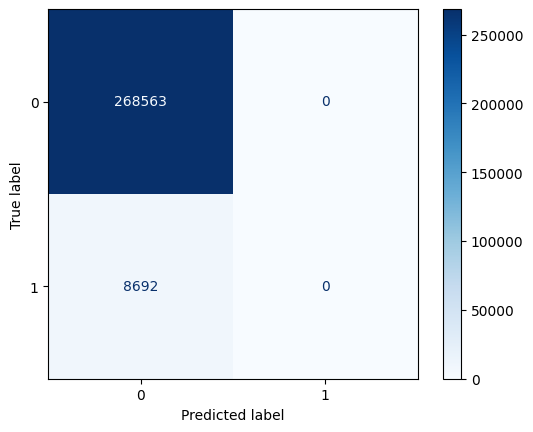

In [44]:
cm = confusion_matrix(y_val, (preds + 0.5) // 1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.show()

## Resampling with SMOTE

In [50]:
oversample = imblearn.over_sampling.SMOTE()
X_train_res, y_train_res = oversample.fit_resample(imp_X_train_encoded, y_train)

In [51]:
lgb_train_res = lightgbm.Dataset(X_train_res, label=y_train_res)
lgb_valid_res = lightgbm.Dataset(imp_X_val_encoded, label=y_val, reference=lgb_train_res)

model = lightgbm.train(
    params,
    lgb_train_res,
    valid_sets=lgb_valid_res,
    callbacks=[lightgbm.log_evaluation(100), lightgbm.early_stopping(100)]
)

/Users/waynelam/Desktop/CUNY/CCNY/Spring24_Final_Projects/ML/machine-learning-dse-i210-final-project-credit-risk/amp-env/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 1
Early stopping, best iteration is:
[1]	valid_0's auc: 1


In [52]:
preds = model.predict(imp_X_val_encoded, num_iteration=model.best_iteration)
preds_binary = [ 1 if pred >= 0.5 else 0 for pred in preds ]

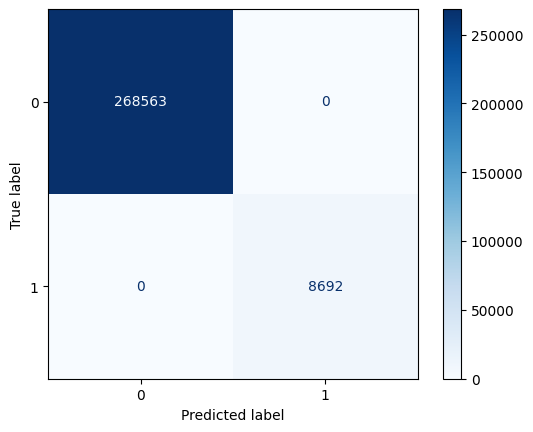

In [53]:
cm = confusion_matrix(y_val, (preds + 0.5) // 1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.show()

In [54]:
feat_imp = model.feature_importance()
pred_cols = X_train_res.columns

feat_df_1 = pd.DataFrame({'feature': pred_cols, 'importance': feat_imp})
feat_df_1 = feat_df_1.sort_values(by='importance', ascending=False)

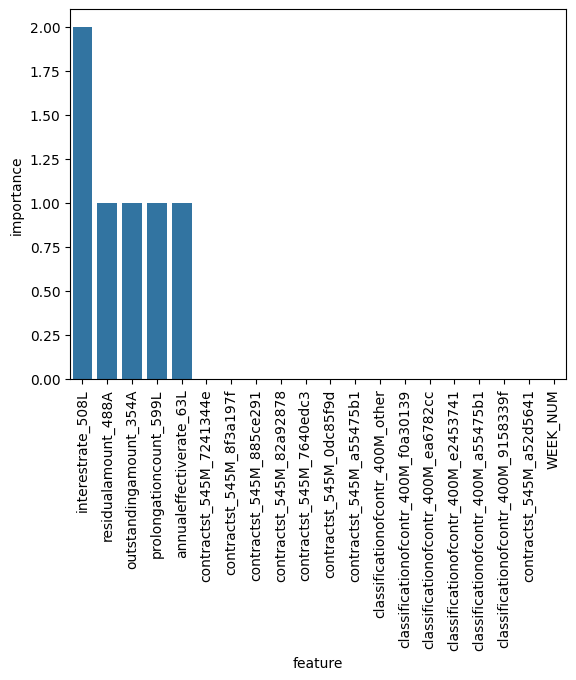

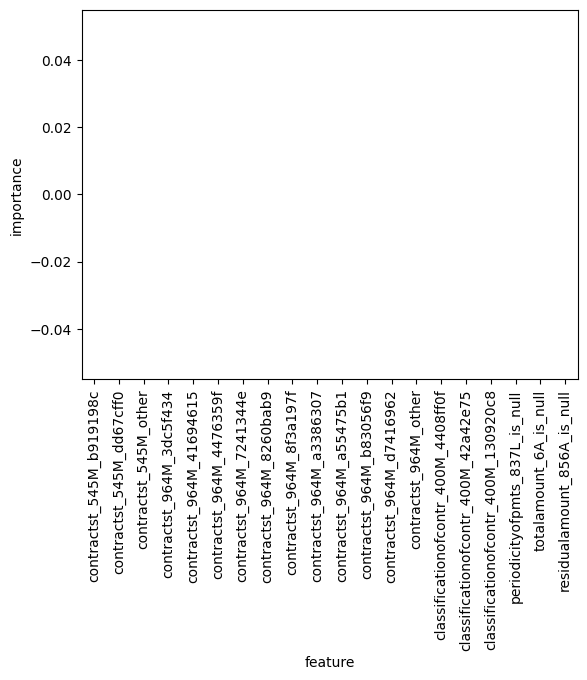

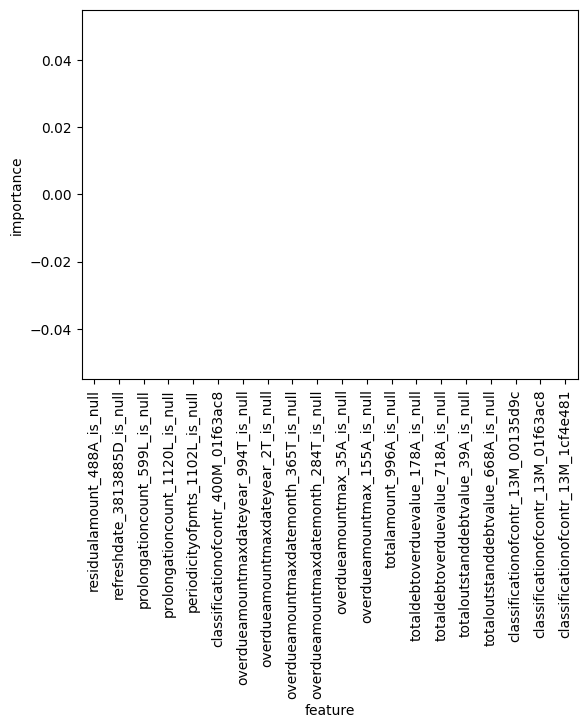

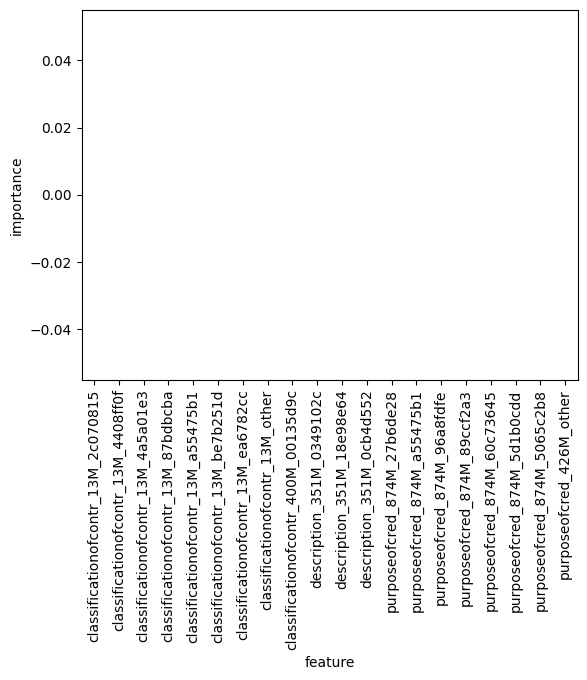

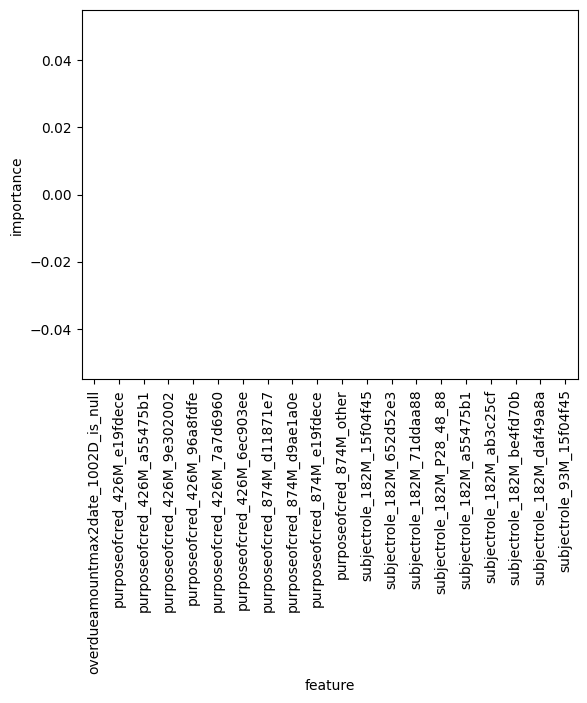

In [55]:
for i in range(100 // 20):
    start = i*20
    end = start + 20
    sns.barplot(feat_df_1.iloc[start:end, :], x='feature', y='importance')
    plt.xticks(rotation=90)

    plt.show()